In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np
import os, random,sys
from PIL import Image


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
!unzip /content/lfw.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: /content/__M

In [5]:
path = '/content/lfw'

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
if torch.cuda.is_available():
    # Check if MPS is available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device.")
    else:
        device = torch.device("cuda")
        print("Using CUDA device.")
else:
    # If CUDA is not available, use CPU
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

Using CUDA device.


torch.Size([250, 250, 3])


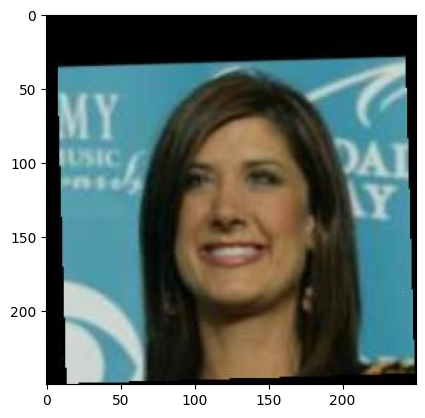

In [17]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [9]:
# Get one batch from the DataLoader
for x, y in dataloader:
    # Print dimensions
    print(f"Sample dimensions: {x[0].shape}")
    break


Sample dimensions: torch.Size([3, 250, 250])


**The** dimensions represent the shape of the image, typically in the form (channels, height, width) or (height, width, channels), depending on the library and conventions used.
C (Channels): Represents the color channels in the image.
H (Height): Represents the number of pixels along the vertical axis.
W (Width): Represents the number of pixels along the horizontal axis.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Definition
        # The encoder compresses the input into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            # First convolutional layer reduces spatial dimensions and increases depth
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # Activation function to introduce non-linearity
            nn.BatchNorm2d(32),  # Normalizes the output of the previous layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling reduces spatial dimensions further
        )

        # Decoder Definition
        # The decoder reconstructs the input from the lower-dimensional latent space
        self.decoder = nn.Sequential(
            # First transposed convolutional layer starts the upsampling process
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),  # Activation function
            nn.BatchNorm2d(32),  # Normalization
            # Final layer upsamples to the original image size and reduces depth to original
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),  # Sigmoid activation to output values in the range [0, 1]
        )

    def forward(self, x):
        # Forward pass through the autoencoder
        x = self.encoder(x)  # Pass input through the encoder
        x = self.decoder(x)  # Pass the encoded output through the decoder
        return x

# Create an instance of the Autoencoder model
autoencoder_model = AE()

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [11]:
ae_model = AE().to(device)
batch = next(iter(dataloader))

# Get the image batch and move it to the device (e.g., GPU)
input_images = batch[0].to(device)

print(f"Input image :{input_images.shape}")

# Perform a forward pass through the encoder
encoder_output = ae_model.encoder(input_images)
print(f"Encoder output shape: {encoder_output.shape}")

# Perform a forward pass through the decoder
decoder_output = ae_model.decoder(encoder_output)
print(f"Decoder output shape: {decoder_output.shape}")

Input image :torch.Size([32, 3, 250, 250])
Encoder output shape: torch.Size([32, 32, 62, 62])
Decoder output shape: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [12]:
import torch.optim as optim

total_params = sum(p.numel() for p in ae_model.parameters())
print(f'Total Parameters: {total_params}')

loss_function =torch.nn.MSELoss()
# Create an optimizer for training
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)


Total Parameters: 18979


For training, the Mean Squared Error (MSE) loss function is used. It is ideal for image reconstruction tasks as it minimizes the pixel-wise difference between the original and reconstructed images. The optimizer, Adam, with a learning rate of 0.001, is chosen for its efficiency in updating the model's parameters, balancing the speed and stability of learning.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [13]:
# Set the number of training epochs
num_epochs = 10

# Move the model to the selected device (CPU or GPU)
ae_model.to(device)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    # Iterate over the dataset
    for inputs, _ in dataloader:
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ae_model(inputs)

        # Compute the loss without resizing
        loss = loss_function(outputs, inputs[:, :, :outputs.size(2), :outputs.size(3)])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

    # Check if the loss is not decreasing
    if epoch > 0 and average_loss >= prev_loss:
        print("Warning: Loss is not decreasing!")

    prev_loss = average_loss

# Save the trained model
torch.save(ae_model.state_dict(), 'autoencoder_model.pth')


Epoch 1/10, Loss: 0.007355878864086553
Epoch 2/10, Loss: 0.0020441587936754027
Epoch 3/10, Loss: 0.001680571857529382
Epoch 4/10, Loss: 0.001400635505611401
Epoch 5/10, Loss: 0.001344158107207881
Epoch 6/10, Loss: 0.001303558396164256
Epoch 7/10, Loss: 0.0012309910079401328
Epoch 8/10, Loss: 0.0011298141401746998
Epoch 9/10, Loss: 0.0011088327499914122
Epoch 10/10, Loss: 0.0010300445086930108


If the loss is not decreasing during the training of your autoencoder, it indicates that the model is not learning effectively. Here are some steps to troubleshoot this issue:


*   Adjust Learning Rate
*   Increase Epochs
*   Review Data Preprocessing
*   Check Model Architecture
*   Inspect Loss Function
*   Batch Size Adjustment

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

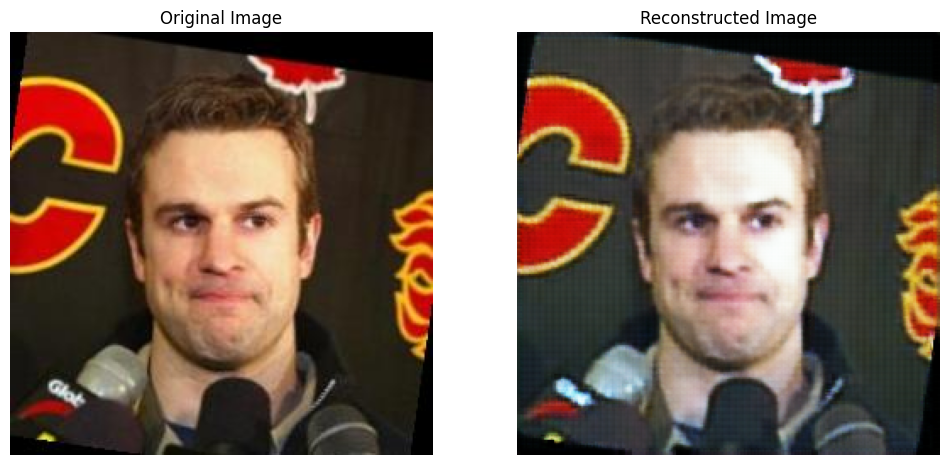

In [14]:
# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through your autoencoder
with torch.no_grad():
    reconstructed = ae_model(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Ensure that the pixel values are in the [0, 1] range
reconstructed_np = np.clip(reconstructed_np, 0, 1)

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

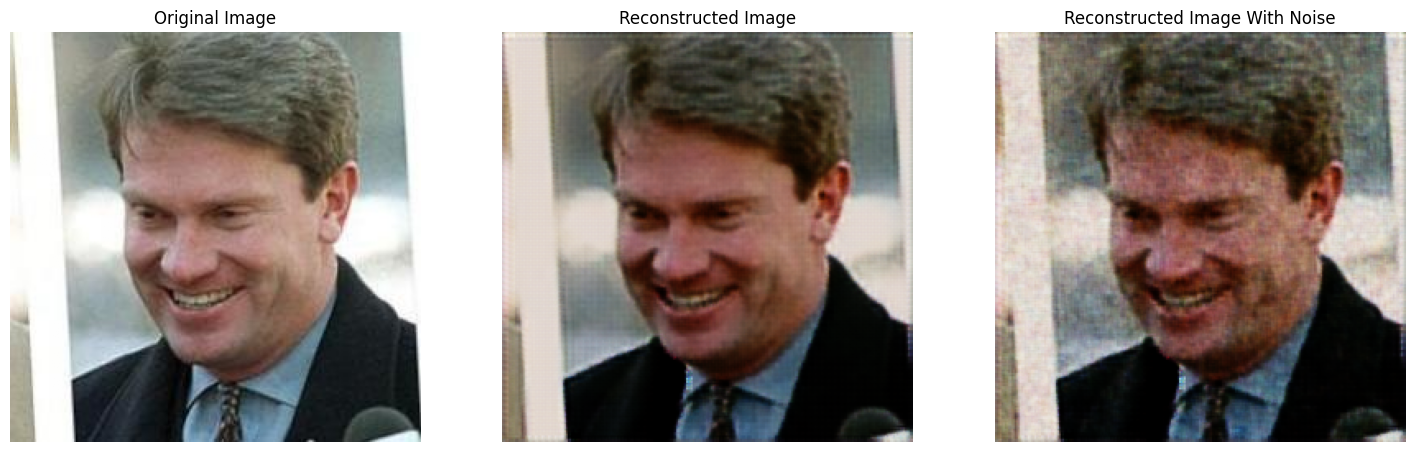

In [16]:
# Get a single batch from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select the first image from the batch
original_image = images[0]
original_image_np = original_image.numpy().transpose(1, 2, 0)

# Move the image to the device and add a batch dimension
input_image = original_image.unsqueeze(0).to(device)

# Pass the image through your autoencoder
with torch.no_grad():
    # First decode without noise
    reconstructed = ae_model(input_image)
    reconstructed_np = reconstructed.cpu().squeeze(0).numpy().transpose(1, 2, 0)

    # Then add noise to the latent representation
    encoded = ae_model.encoder(input_image)
    noise = torch.randn_like(encoded) * 0.2  # You can adjust the noise factor here
    encoded_with_noise = encoded + noise

    # Decode the noisy encoded representation
    decoded_with_noise = ae_model.decoder(encoded_with_noise)
    reconstructed_with_noise_np = decoded_with_noise.cpu().squeeze(0).numpy().transpose(1, 2, 0)

# Ensure that the pixel values are in the [0, 1] range
reconstructed_np = np.clip(reconstructed_np, 0, 1)
reconstructed_with_noise_np = np.clip(reconstructed_with_noise_np, 0, 1)

# Plot the original, reconstructed, and reconstructed with noise images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_with_noise_np)
plt.title("Reconstructed Image With Noise")
plt.axis('off')

plt.show()




*   Adding small normally distributed noise to the latent representation introduces subtle variations in the decoded image, making it appear slightly distorted or less sharp compared to the reconstruction without noise. This noise can mimic imperfections in the original image.



